In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sp
import itertools

In [2]:
# Parameters
L = 1.0          # Domain length
N = 64           # Number of grid points
x = np.linspace(0, L, N, endpoint=False)  # Grid points

# Source term f(x) = sin(2πx/L)
f = np.sin(2 * np.pi * x / L)

# Compute FFT of f
f_hat = fft(f)

# Define wavevectors k (scaled by 2π/L)
k = 2 * np.pi * fftfreq(N, d=L/N)
k_sq = k**2
k_sq[0] = np.inf  # Avoid division by zero (k=0 mode is handled separately)

# Green's function in Fourier space
G_hat = 1 / k_sq

# Solve in Fourier space
u_hat = G_hat * f_hat

# Handle k=0 mode (enforce zero mean)
u_hat[0] = 0

# Inverse FFT to get u(x)
u = ifft(u_hat).real

# Analytical solution
u_exact = (L**2 / (2 * np.pi)**2) * np.sin(2 * np.pi * x / L)

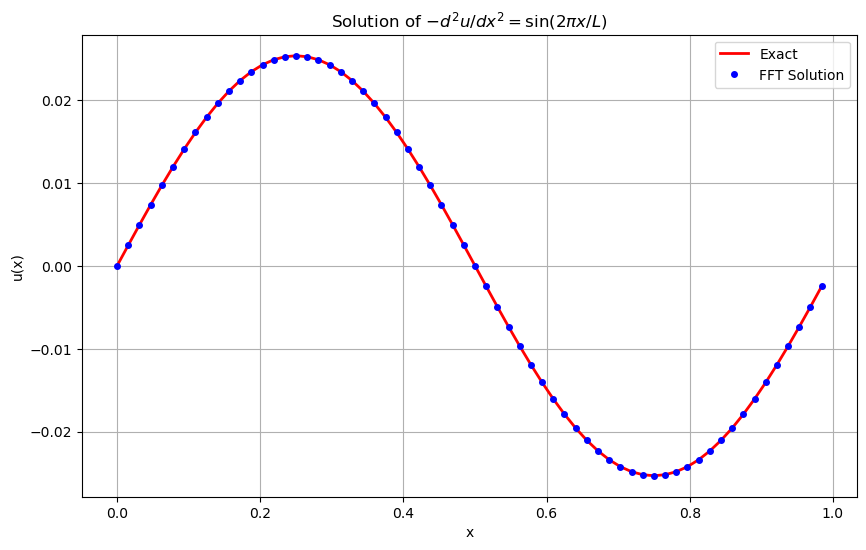

In [3]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, u_exact, 'r-', linewidth=2, label='Exact')
plt.plot(x, u, 'bo', markersize=4, label='FFT Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Solution of $-d^2u/dx^2 = \sin(2\pi x/L)$')
plt.grid(True)
plt.show()

In [4]:
# Copied from: https://github.com/Firdes/FFT-based-Homogenization
# Modified by Tianju for being better aligned with numpy.fft convention
# In the original code (Firdes), the frequency axis and the coordinate axis both start from -(N-1)/2. to +(N+1)/2.,
# while in the current code, they both range as 0,1,...,N-1

# The algorithm is from
# Moulinec, Hervé, and Pierre Suquet. 
# "A numerical method for computing the overall response of nonlinear composites with complex microstructure." 
# Computer methods in applied mechanics and engineering 157, no. 1-2 (1998): 69-94.

################# STANDARD FFT-HOMOGENIZATION by Moulinec & Suquet (1994) ###############

# ----------------------------------- GRID ------------------------------------

ndim   = 3            # number of dimensions
N      = 31           # number of voxels (assumed equal for all directions, needs to be an odd number)
ndof   = ndim**2*N**3 # number of degrees-of-freedom

# ---------------------- PROJECTION, TENSORS, OPERATIONS ----------------------

# tensor operations/products: np.einsum enables index notation, avoiding loops
trans2 = lambda A2 : np.einsum('ijxyz          ->jixyz  '     ,A2)
ddot42 = lambda A4,B2: np.einsum('ijklxyz,lkxyz  ->ijxyz  ',A4,B2)
dot22  = lambda A2,B2: np.einsum('ijxyz  ,jkxyz  ->ikxyz  ',A2,B2)
dyad22 = lambda A2,B2: np.einsum('ijxyz  ,klxyz  ->ijklxyz',A2,B2)

# identity tensor                                               [single tensor]
i      = np.eye(ndim)
# identity tensors                                            [grid of tensors]
I      = np.einsum('ij,xyz'           ,                  i   ,np.ones([N,N,N]))
I4     = np.einsum('ijkl,xyz->ijklxyz',np.einsum('il,jk',i,i),np.ones([N,N,N]))
I4rt   = np.einsum('ijkl,xyz->ijklxyz',np.einsum('ik,jl',i,i),np.ones([N,N,N]))
I4s    = (I4+I4rt)/2. # symm. 4th order tensor
II     = dyad22(I,I)  # dyadic product of 2nd order unit tensors

# ------------------- PROBLEM DEFINITION / CONSTITIVE MODEL -------------------

# phase indicator: cubical inclusion of volume fraction 
# here: inclusion has cylinder form
phase  = np.zeros([N,N,N])
r = np.sqrt((0.2*N**2)/np.pi) #radius of cylinder (20% volume fraction)
for i in range(N):
    for j in range(N):
        for k in range(N):
            if ((i-int(N/2))**2 + (k-int(N/2))**2) <= r:
                phase[i,j,k]=1.

# material parameters + function to convert to grid of scalars
param   = lambda M1,M2: M1*np.ones([N,N,N])*(1.-phase)+M2*np.ones([N,N,N])*phase
lambda1 = 10.0
lambda2 = 100.0
lambdas = param(lambda1, lambda2)  # Lamé constants (material1, material2)  [grid of scalars]
mu1     = 0.25
mu2     = 2.5
mu      = param(mu1, mu2)          # shear modulus [grid of scalars]
## stiffness tensor                [grid of scalars]  
C4      = lambdas*II+2.*mu*I4s 

# ------------------------------------------------------------------------------

## projection operator                            [grid of tensors]
delta   = lambda i,j: float(i==j)              # Dirac delta function
freq    = np.arange(-(N-1)/2.,+(N+1)/2.)          # coordinate axis -> freq. axis

# Modified from the original copy (Firdes)
freq = np.fft.ifftshift(freq)

lambda0 = (lambda1 + lambda2)/2                   # Lamé constant for isotropic reference material
mu0     = (mu1 + mu2)/2                           # shear modulus for isotropic reference material
const   = (lambda0 + mu0)/(mu0*(lambda0 + 2*mu0))
Greens  = np.zeros([ndim,ndim,ndim,ndim,N,N,N])   # Green's function in Fourier space

for k,h,i,j in itertools.product(range(ndim), repeat=4):
    for x,y,z in itertools.product(range(N), repeat=3):
        q = np.array([freq[x], freq[y], freq[z]]) # frequency vector
        if not q.dot(q) == 0: # zero freq. -> mean
            Greens[k,h,i,j,x,y,z] = (1/(4*mu0*q.dot(q))*\
             (delta(k,i)*q[h]*q[j]+delta(h,i)*q[k]*q[j]+\
              delta(k,j)*q[h]*q[i]+delta(h,j)*q[k]*q[i]))-\
              (const*((q[i]*q[j]*q[k]*q[h])/(q.dot(q))**2))

# Simplified from the original copy (Firdes)
# (inverse) Fourier transform (for each tensor component in each direction)
fft  = lambda x: np.fft.fftn (x, [N,N,N])
ifft = lambda x: np.fft.ifftn(x, [N,N,N])

# inner functions to produce IB matrix, IB = I - F^{-1} *Gamma*F*C --> eps_i+1 = IB*eps_i 
G           = lambda x: np.real(ifft(ddot42(Greens,fft(x)))).reshape(-1)
Stiff_Mat   = lambda x: ddot42(C4,x.reshape(ndim,ndim,N,N,N))
G_Stiff_Mat = lambda x: G(Stiff_Mat(x))
Id          = lambda x: ddot42(I4,x.reshape(ndim,ndim,N,N,N)).reshape(-1)
IB          = lambda x: np.add(Id(x),-1.*G_Stiff_Mat(x))

# # ----------------------------- NEWTON ITERATIONS -----------------------------

# initialize stress and strain for each 6 macroscopic strain E  
sig = [np.zeros([ndim,ndim,N,N,N]) for _ in range(6)]
eps = [np.zeros([ndim,ndim,N,N,N]) for _ in range(6)]

# set macroscopic strains, total:6 (for each direction)
E   = [np.zeros([ndim,ndim,N,N,N]) for _ in range(6)]

E[0][0][0] = 1.0 # loading in 1,1 direction 
E[1][1][1] = 1.0 # loading in 2,2 direction
E[2][2][2] = 1.0 # loading in 3,3 direction
E[3][0][1] = 1.0 # loading in 1,2 direction
E[3][1][0] = 1.0 # loading in 2,1 direction (due to symmetry)
E[4][1][2] = 1.0 # loading in 2,3 direction
E[4][2][1] = 1.0 # loading in 3,2 direction (due to symmetry)
E[5][0][2] = 1.0 # loading in 1,3 direction
E[5][2][0] = 1.0 # loading in 3,1 direction (due to symmetry)

iiter = [0 for _ in range(6)]

# --------------- for convergence criteria ----------------

freqMat = np.zeros([ndim, 1, N, N, N])      #[grid of scalars]
for j in range(ndim):
    for x in range(N):
        for y in range(N):
            for z in range(N):
                if j==0:
                    freqMat[j,0,x,y,z] = freq[x]
                elif j==1:
                    freqMat[j,0,x,y,z] = freq[y]
                elif j==2:
                    freqMat[j,0,x,y,z] = freq[z] 

freqMat_T = trans2(freqMat)

# c         = int((N-1)/2)                    # center of frequency grid
c         = 0                    # changed to zero by Tianju

# ---------------------------------------------------------

for i in range(0,6):
    sigma = np.zeros([ndim,ndim,N,N,N])
    eps[i] += E[i]
    print(f"i = {i}")
    while True:
        eps[i]   = IB(eps[i])
        sigma    = Stiff_Mat(eps[i])

        # ---------------- (equilibrium-based) convergence criteria -------------------------
        fou_sig  = fft(sigma).reshape(ndim, ndim, N,N,N)
        nom      = np.sqrt(np.mean(np.power(dot22(freqMat_T, fou_sig),2))) #nominator
        denom    = np.sqrt(np.real(fou_sig[0,0,c,c,c]**2 + fou_sig[1,1,c,c,c]**2 +\
                    fou_sig[2,2,c,c,c]**2 + fou_sig[0,1,c,c,c]**2 +\
                    fou_sig[1,2,c,c,c]**2 + fou_sig[0,2,c,c,c]**2)) # denominator
        # ---------------------------------------------------------------
        
        if np.abs(nom/denom) <1.e-8 and iiter[i]>0: break
        iiter[i] += 1

        print(f"nom = {nom}, {denom} = {denom}, res = {nom/denom}")

# homogenized stiffness
homStiffness = np.zeros([6, 6])

# homogenization operation <f> = 1/N Σ f_i
for i in range(6):
    sig[i] = Stiff_Mat(eps[i])
    homStiffness[0][i] = round((1.0/(N**3))*np.sum(sig[i][0][0]),4)
    homStiffness[1][i] = round((1.0/(N**3))*np.sum(sig[i][1][1]),4)
    homStiffness[2][i] = round((1.0/(N**3))*np.sum(sig[i][2][2]),4)
    homStiffness[3][i] = round((1.0/(N**3))*np.sum(sig[i][0][1]),4)
    homStiffness[4][i] = round((1.0/(N**3))*np.sum(sig[i][1][2]),4)
    homStiffness[5][i] = round((1.0/(N**3))*np.sum(sig[i][2][0]),4)

print("Homogenized Stiffness: \n", homStiffness)

i = 0
nom = (2182.765431357932+3.910899629964117e-14j), 466720.6908188463 = 466720.6908188463, res = (0.004676813079635148+8.379529142156887e-20j)
nom = (1646.5601029423817+2.5922456467096007e-14j), 586827.0524575175 = 586827.0524575175, res = (0.002805869456847479+4.4173928857808793e-20j)
nom = (1237.734576353868+8.621170363260899e-14j), 497222.7286886309 = 497222.7286886309, res = (0.0024892960537388426+1.7338648991365032e-19j)
nom = (934.4873752114349+4.567518376513506e-14j), 564114.0662128419 = 564114.0662128419, res = (0.001656557478676396+8.096799300143967e-20j)
nom = (702.929177442058+3.036072762287587e-14j), 514153.01453264407 = 514153.01453264407, res = (0.0013671594983859193+5.904998466356019e-20j)
nom = (531.2385182524704-2.0086496518262643e-14j), 551477.9034419758 = 551477.9034419758, res = (0.0009632997350153396-3.642303053829619e-20j)
nom = (399.94270741416045+0j), 523586.69444462436 = 523586.69444462436, res = (0.0007638519306499666+0j)
nom = (302.5919199975635-8.8160984